# Real NVP with distribution learning for molecular confomations

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pytraj as pt
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from sys import stdout
%matplotlib inline

#import tensorflow.contrib.eager as tfe # For eager mode
#tfe.enable_eager_execution()

/Users/tachi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Setting for Real NVP
tf.set_random_seed(0)
sess = tf.InteractiveSession()
tfd = tf.contrib.distributions
tfb = tfd.bijectors

DTYPE = tf.float32
NP_DTYPE = np.float32
MODEL = 'NVP' # Which Normalizing Flow to use. 'NVP' or 'MAF' or 'IAF'
USE_BATCHNORM = True


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
# Get molecular conformations from the MD data set of alanine dipeptide.
batch_size = 1000
pos_list = []

for i in range(1, batch_size + 1):
    filename = '/Users/tachi/Development/md-alanine-dipeptide/outputs/dcd_convert.pdb.%d' % i
    pdb = PDBFile(filename)
    pos = pdb.getPositions(asNumpy=True) / nanometer
    pos_flatten = list(pos.flatten().astype(np.float32))
    pos_list.append(pos_flatten)

converted_list = tf.convert_to_tensor(pos_list)

In [4]:
# Generate and sample a source distribution
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([np.shape(pos_list)[1]], dtype=tf.float32))
base_samples = base_dist.sample(batch_size)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlo

In [5]:
# Real NVP
def net(x, out_size):
    return tf.contrib.layers.stack(x, tf.contrib.layers.fully_connected, [512, 512, out_size])

# Affine Coupling layer for Real-NVP
class NVPCoupling(tfb.Bijector):
    """NVP affine coupling layer for 2D units.
    """

    def __init__(self, D, d, layer_id=0, validate_args=False, name="NVPCoupling"):
        """
        Args:
          d: First d units are pass-thru units.
        """
        # first d numbers decide scaling/shift factor for remaining D-d numbers.
        super(NVPCoupling, self).__init__(
             forward_min_event_ndims=1, 
            validate_args=validate_args, 
            name=name
        )
        self.D, self.d = D, d
        self.id = layer_id
        # create variables here
        tmp = tf.placeholder(dtype=DTYPE, shape=[1, self.d])
        self.s(tmp)
        self.t(tmp)

    def s(self, xd):
        with tf.variable_scope('s%d' % self.id, reuse=tf.AUTO_REUSE):
            return net(xd, self.D - self.d) # Adjust the number of dimensions for the hadamard product

    def t(self, xd):
        with tf.variable_scope('t%d' % self.id, reuse=tf.AUTO_REUSE):
            return net(xd, self.D - self.d) # Adjust the number of dimensions for the hadamard product

    def _forward(self, x):
        xd, xD = x[:, :self.d], x[:, self.d:]
        yD = xD * tf.exp(self.s(xd)) + self.t(xd)  # [batch, D-d]
        return tf.concat([xd, yD], axis=1)

    def _inverse(self, y):
        yd, yD = y[:, :self.d], y[:, self.d:]
        xD = (yD - self.t(yd)) * tf.exp(-self.s(yd))
        return tf.concat([yd, xD], axis=1)

    def _forward_log_det_jacobian(self, x):
        event_dims = tf.cast(self._forward_event_shape_tensor(x), dtype=tf.int32)
        xd = x[:, :self.d]
        return tf.reduce_sum(self.s(xd), axis=1)
    
    def _inverse_log_det_jacobian(self, y):
        return -self._forward_log_det_jacobian(y)

***
### NICE (volume preserving)
$$
\rm{Forward\ addictive\ coupling\ layer}\ \it{f_{xz}}\rm{:}\\
\mathbf{z}_{\rm 1} = \mathbf{x}_{\rm 1}\\
\mathbf{z}_{\rm 2} = \mathbf{x}_{\rm 2} + T(\mathbf{x}_{\rm 1};\theta)\\
$$
$$
\rm{Inverse\ addictive\ coupling\ layer}\ \it{f_{zx}}\rm{:}\\
\mathbf{x}_{\rm 1} = \mathbf{z}_{\rm 1}\\
\mathbf{x}_{\rm 2} = \mathbf{z}_{\rm 2} - T(\mathbf{z}_{\rm 1};\theta)\\
$$
$$
\rm{Forward\ Jacobian\ determinant}\ \it{R_{xz}}\rm{:}\ 1
$$
$$
\rm{Inverse\ Jacobian\ determinant}\ \it{R_{zx}}\rm{:}\ 1
$$
***
### Real NVP (non volume preserving)
$$
\rm{Forward\ affine\ coupling\ layer}\ \it{f_{xz}}\rm{:}\\ 
\mathbf{z}_{\rm 1} = \mathbf{x}_{\rm 1}\\
\mathbf{z}_{\rm 2} = \mathbf{x}_{\rm 2}\odot \exp(-\ S(\mathbf{x}_{\rm 1};\theta)) + T(\mathbf{x}_{\rm 1};\theta)\\
$$
$$
\rm{Inverse\ affine\ coupling\ layer}\ \it{f_{zx}}\rm{:}\\
\mathbf{x}_{\rm 1} = \mathbf{z}_{\rm 1}\\
\mathbf{x}_{\rm 2} = \mathbf{z}_{\rm 2}\odot \exp(-\ S(\mathbf{z}_{\rm 1};\theta)) - T(\mathbf{z}_{\rm 1};\theta)\\
$$
$$
\rm{Forward\ Jacobian\ determinant}\ \it{R_{xz}}\rm{:}\ 
\mathrm{e}^{\sum_{\it i} S(\mathbf{x}_{1};\theta)_{\it i}}
$$
$$
\rm{Inverse\ Jacobian\ determinant}\ \it{R_{zx}}\rm{:}\ 
\mathrm{e}^{-\sum_{\it i}S(\mathbf{z}_{1};\theta)_{\it i}}
$$
***

In [6]:
# BatchNorm Bijector
class BatchNorm(tfb.Bijector):
    def __init__(self, eps=1e-5, decay=0.95, validate_args=False, name="batch_norm"):
        super(BatchNorm, self).__init__(
             forward_min_event_ndims=1, validate_args=validate_args, name=name)
        self._vars_created = False
        self.eps = eps
        self.decay = decay

    def _create_vars(self, x):
        n = x.get_shape().as_list()[1]
        with tf.variable_scope(self.name):
            self.beta = tf.get_variable('beta', [1, n], dtype=DTYPE)
            self.gamma = tf.get_variable('gamma', [1, n], dtype=DTYPE)
            self.train_m = tf.get_variable('mean', [1, n], dtype=DTYPE, trainable=False)
            self.train_v = tf.get_variable('var', [1, n], dtype=DTYPE, 
                initializer=tf.ones_initializer, trainable=False)
        self._vars_created = True

    def _forward(self, u):
        if not self._vars_created:
            self._create_vars(u)
        return (u - self.beta) * tf.exp(-self.gamma) * tf.sqrt(self.train_v + self.eps) + self.train_m

    def _inverse(self, x):
        # Eq 22. Called during training of a normalizing flow.
        if not self._vars_created:
            self._create_vars(x)
        # statistics of current minibatch
        m, v = tf.nn.moments(x, axes=[0], keep_dims=True)
        # update train statistics via exponential moving average
        update_train_m = tf.assign_sub(
            self.train_m, self.decay * (self.train_m - m))
        update_train_v = tf.assign_sub(
            self.train_v, self.decay * (self.train_v - v))
        # normalize using current minibatch statistics, followed by BN scale and shift
        with tf.control_dependencies([update_train_m, update_train_v]):
            return (x - m) * 1. / tf.sqrt(v + self.eps) * tf.exp(self.gamma) + self.beta

    def _inverse_log_det_jacobian(self, x):
        # at training time, the log_det_jacobian is computed from statistics of the
        # current minibatch.
        if not self._vars_created:
            self._create_vars(x)
        _, v = tf.nn.moments(x, axes=[0], keep_dims=True)
        abs_log_det_J_inv = tf.reduce_sum(self.gamma - .5 * tf.log(v + self.eps))
        return abs_log_det_J_inv

In [7]:
# Construct the flow
bijectors = []
num_layers = 2
nd = np.shape(pos_list)[1]
sepdim = int(nd / 2)
perm_list = list(reversed([i for i in range(0, nd)]))

for i in range(num_layers):
    if MODEL == 'NVP':
        bijectors.append(NVPCoupling(D=nd, d=sepdim, layer_id=i))
    elif MODEL == 'MAF':
        bijectors.append(tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_layers=[512, 512])))
    elif MODEL == 'IAF':
        bijectors.append(tfb.Invert(tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_layers=[512, 512]))))
    if USE_BATCHNORM and i % 2 == 0:
        # BatchNorm helps to stabilize deep normalizing flows, esp. Real-NVP
        bijectors.append(BatchNorm(name='batch_norm%d' % i))
    bijectors.append(tfb.Permute(permutation=perm_list))
# Discard the last Permute layer.
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=flow_bijector
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.


In [8]:
# Visualize the flow (before optimization)
x = base_dist.sample(batch_size)
samples = [x]
names = [base_dist.name]

for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

In [9]:
sess.run(tf.global_variables_initializer())

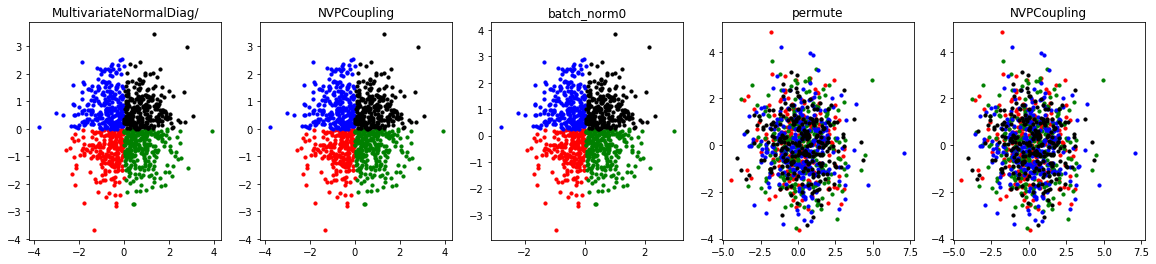

In [10]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]

for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    #arr[i].set_xlim([-2, 2])
    #arr[i].set_ylim([-2, 2])
    arr[i].set_title(names[i])

In [11]:
# Optimize the flow
loss = -tf.reduce_mean(dist.log_prob(converted_list))
train_op = tf.train.AdamOptimizer(1e-3).minimize(loss)
sess.run(tf.global_variables_initializer())
NUM_STEPS = int(10000)
global_step = []
np_losses = []

for i in range(NUM_STEPS):
    _, np_loss = sess.run([train_op, loss])
    if i % 10 == 0:
        global_step.append(i)
        np_losses.append(np_loss)
    if i % int(1e3) == 0:
        print(i, np_loss)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
Use tf.cast instead.
0 -115.92453
1000 -182.36853
2000 -197.87239
3000 -206.25435
4000 -212.54453
5000 -216.1845
6000 -220.19717
7000 -217.99548
8000 -221.45535
9000 -223.70384


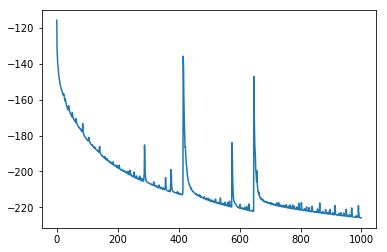

In [12]:
# Plot the loss function
start = 0
plt.plot(np_losses[start:])

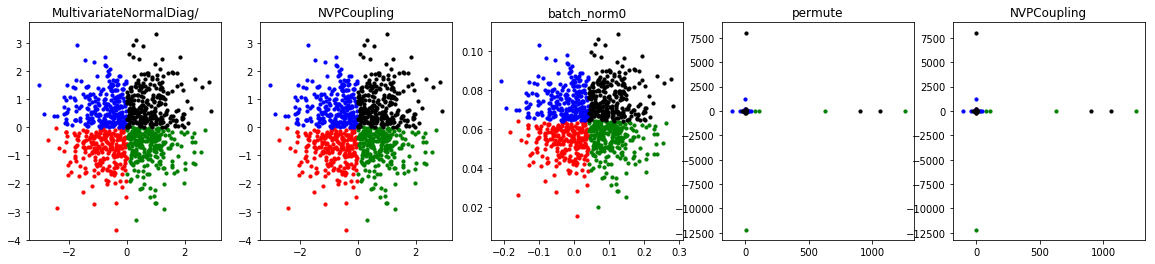

In [13]:
# Visualize the normalizing flow
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]

for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    #arr[i].set_xlim([-2, 2])
    #arr[i].set_ylim([-2, 2])
    arr[i].set_title(names[i])

<IPython.core.display.Javascript object>


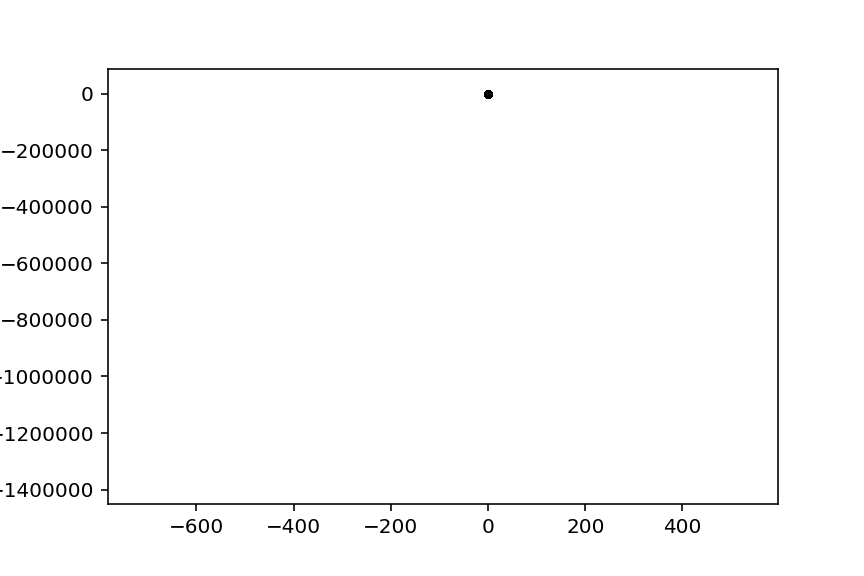

In [15]:
# Animation
%matplotlib nbagg
# We can only use this magic comment on Jupyter Notebook so far (15/07/2019).
import matplotlib.animation as animation
results = sess.run(samples)
X0 = results[0]
images = []
fig = plt.figure()

for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    image1 = plt.scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    image2 = plt.scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    image3 = plt.scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    image4 = plt.scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    #arr[i].set_xlim([-2, 2])
    #arr[i].set_ylim([-2, 2])
    images.append([image1] +[image2] +[image3] + [image4])
    
ani = animation.ArtistAnimation(fig, images, interval=1000)
ani.save('anim.gif', writer="imagemagick")
plt.show()

In [25]:
# Understanding the flow by Tensorboard
summary_writer = tf.summary.FileWriter('data', graph=sess.graph)
tf.summary.scalar('summary', samples)

<tf.Tensor 'summary:0' shape=() dtype=string>

In [16]:
# Visualize the flow (Generation)
test = base_dist.sample(10000)
test_samples = [test]
test_names = [base_dist.name]

for bijector in reversed(dist.bijector.bijectors):
    test = bijector.forward(test)
    test_samples.append(test)
    test_names.append(bijector.name)

Traceback (most recent call last):
  File "/Users/tachi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/Users/tachi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/Users/tachi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/animation.py", line 1499, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


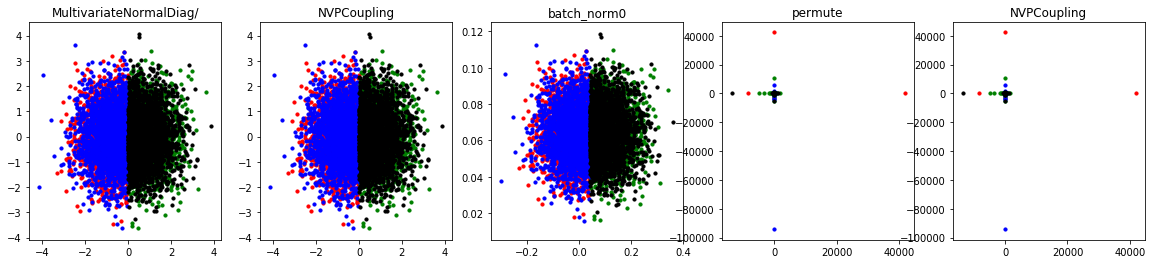

In [17]:
%matplotlib inline
results = sess.run(test_samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]

for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 2] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 2] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 2] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 2] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    #arr[i].set_xlim([-2, 2])
    #arr[i].set_ylim([-2, 2])
    arr[i].set_title(names[i])

In [21]:
# Write the samples generated from real NVP
temp = 310
delta = 0.002

prmtop = AmberPrmtopFile('/Users/tachi/Development/md-alanine-dipeptide/inputs/adip.prmtop')
inpcrd = AmberInpcrdFile('/Users/tachi/Development/md-alanine-dipeptide/inputs/adip.inpcrd')
system = prmtop.createSystem(implicitSolvent=GBn, nonbondedCutoff=1 * nanometer,
        constraints=HBonds)
integrator = LangevinIntegrator(temp * kelvin, 1 / picosecond, delta * picoseconds)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
    simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

In [30]:
for i,p in enumerate(results[0]):
    filename = 'outputs/test_gen.pdb.%d' % i
    with open(filename,'a') as f:
        PDBFile.writeFile(topology=prmtop.topology, positions=p.reshape(22,3) * nanometer, file=f)

In [32]:
#  Calculate potential energies from each frame
pe_list = []
unit = kilojoule / mole
for i in range(1, len(results[0])):
    filename = 'outputs/test_gen.pdb.%d' % i
    pdb = PDBFile(filename)
    simulation.context.setPositions(pdb.getPositions())
    state = simulation.context.getState(getEnergy=True)
    pe_list.append(state.getPotentialEnergy() / unit)
    print(i, state.getPotentialEnergy())

1 7419971.5 kJ/mol
2 8123933.0 kJ/mol
3 700497019273216.0 kJ/mol
4 10527901.0 kJ/mol
5 11551000.0 kJ/mol
6 8885628.0 kJ/mol
7 3676254.5 kJ/mol
8 9743132.0 kJ/mol
9 6332719.5 kJ/mol
10 4314632.5 kJ/mol
11 11125651.0 kJ/mol
12 17391352.0 kJ/mol
13 11648278.0 kJ/mol
14 7435228.5 kJ/mol
15 8721009.0 kJ/mol
16 11078636.0 kJ/mol
17 5564556.5 kJ/mol
18 11430842.0 kJ/mol
19 7953982.5 kJ/mol
20 5985528.0 kJ/mol
21 4938232.0 kJ/mol
22 10031973.0 kJ/mol
23 4518584.5 kJ/mol
24 5867697.5 kJ/mol
25 5567617.5 kJ/mol
26 5251636.0 kJ/mol
27 10186233.0 kJ/mol
28 3219506.5 kJ/mol
29 15856121.0 kJ/mol
30 3559793.25 kJ/mol
31 6795979.5 kJ/mol
32 6613856.0 kJ/mol
33 4050217.0 kJ/mol
34 8054457.0 kJ/mol
35 6750528.0 kJ/mol
36 5217918.5 kJ/mol
37 8318257.0 kJ/mol
38 15092752.0 kJ/mol
39 5277468.0 kJ/mol
40 7741933.0 kJ/mol
41 6740788.5 kJ/mol
42 7018656.0 kJ/mol
43 7614743.5 kJ/mol
44 7823933.0 kJ/mol
45 10838104.0 kJ/mol
46 10191810.0 kJ/mol
47 10468206.0 kJ/mol
48 7165254.5 kJ/mol
49 10059294.0 kJ/mol
50 89

419 7611391.0 kJ/mol
420 4483645.0 kJ/mol
421 7238844.5 kJ/mol
422 11583888.0 kJ/mol
423 7166437.5 kJ/mol
424 4615556.0 kJ/mol
425 6702631.0 kJ/mol
426 20911926.0 kJ/mol
427 8163678.5 kJ/mol
428 10277520.0 kJ/mol
429 9072498.0 kJ/mol
430 5072674.5 kJ/mol
431 6039661.5 kJ/mol
432 17850620.0 kJ/mol
433 5460721.5 kJ/mol
434 13075826.0 kJ/mol
435 8030928.0 kJ/mol
436 9296019.0 kJ/mol
437 6633928.5 kJ/mol
438 10572802.0 kJ/mol
439 11067137.0 kJ/mol
440 3932123.75 kJ/mol
441 8913628.0 kJ/mol
442 4026028.75 kJ/mol
443 9166750.0 kJ/mol
444 10366097.0 kJ/mol
445 12275375.0 kJ/mol
446 13883962.0 kJ/mol
447 7780097.0 kJ/mol
448 8906377.0 kJ/mol
449 7900048.0 kJ/mol
450 5934700.5 kJ/mol
451 16960592.0 kJ/mol
452 8962599.0 kJ/mol
453 19063444.0 kJ/mol
454 6613181.0 kJ/mol
455 5582744.5 kJ/mol
456 7931563.5 kJ/mol
457 10221482.0 kJ/mol
458 7124766.0 kJ/mol
459 8990798.0 kJ/mol
460 8461239.0 kJ/mol
461 4643509.5 kJ/mol
462 8985758.0 kJ/mol
463 6785707.0 kJ/mol
464 12649717.0 kJ/mol
465 6081804.0 kJ/m

816 6491868.5 kJ/mol
817 7151917.0 kJ/mol
818 6037042.5 kJ/mol
819 5087670.0 kJ/mol
820 6211869.0 kJ/mol
821 10337519.0 kJ/mol
822 4753713.5 kJ/mol
823 9583812.0 kJ/mol
824 6157947.5 kJ/mol
825 5411509.5 kJ/mol
826 5909874.5 kJ/mol
827 6230317.0 kJ/mol
828 4591358.5 kJ/mol
829 10191305.0 kJ/mol
830 5681885.0 kJ/mol
831 6173766.5 kJ/mol
832 7340263.5 kJ/mol
833 4955092.0 kJ/mol
834 17296482.0 kJ/mol
835 9956860.0 kJ/mol
836 12452362.0 kJ/mol
837 12557075.0 kJ/mol
838 7253705.0 kJ/mol
839 8160615.5 kJ/mol
840 10704927.0 kJ/mol
841 6071701.5 kJ/mol
842 6926083.5 kJ/mol
843 6586179.0 kJ/mol
844 4473724.0 kJ/mol
845 7170022.5 kJ/mol
846 4931057.0 kJ/mol
847 8759923.0 kJ/mol
848 1342427136.0 kJ/mol
849 7179429.0 kJ/mol
850 6576875.0 kJ/mol
851 16531509.0 kJ/mol
852 4801470.0 kJ/mol
853 8947947.0 kJ/mol
854 6065630.0 kJ/mol
855 12634715.0 kJ/mol
856 9055227.0 kJ/mol
857 7974040.5 kJ/mol
858 15832752.0 kJ/mol
859 8980541.0 kJ/mol
860 7416533.5 kJ/mol
861 5539412.5 kJ/mol
862 13388972.0 kJ/mol


1207 12537237.0 kJ/mol
1208 8730903.0 kJ/mol
1209 5617750.5 kJ/mol
1210 10214246.0 kJ/mol
1211 11362156.0 kJ/mol
1212 4720138.0 kJ/mol
1213 6110617.0 kJ/mol
1214 10080763.0 kJ/mol
1215 9134201.0 kJ/mol
1216 5794607.5 kJ/mol
1217 11038250.0 kJ/mol
1218 8356384.0 kJ/mol
1219 10272774.0 kJ/mol
1220 5015730.5 kJ/mol
1221 13197657.0 kJ/mol
1222 7017229.5 kJ/mol
1223 10436394.0 kJ/mol
1224 4454534.5 kJ/mol
1225 8504487.0 kJ/mol
1226 5468713.0 kJ/mol
1227 11674220.0 kJ/mol
1228 8582420.0 kJ/mol
1229 6397105.0 kJ/mol
1230 9687078.0 kJ/mol
1231 11435924.0 kJ/mol
1232 5555440.0 kJ/mol
1233 5804490.0 kJ/mol
1234 5548853.5 kJ/mol
1235 9474685.0 kJ/mol
1236 9299574.0 kJ/mol
1237 10586107.0 kJ/mol
1238 7926564.0 kJ/mol
1239 3650687.75 kJ/mol
1240 3514963.5 kJ/mol
1241 4340757.0 kJ/mol
1242 6086575.5 kJ/mol
1243 9465648.0 kJ/mol
1244 6714365.0 kJ/mol
1245 7417049.5 kJ/mol
1246 6344022.0 kJ/mol
1247 6389703.0 kJ/mol
1248 5197013.0 kJ/mol
1249 7321979.0 kJ/mol
1250 6083377.0 kJ/mol
1251 8116002.0 kJ/mo

1584 8128726.0 kJ/mol
1585 6485499.5 kJ/mol
1586 5508980.0 kJ/mol
1587 9428399.0 kJ/mol
1588 7723025.0 kJ/mol
1589 9349982.0 kJ/mol
1590 6203098.5 kJ/mol
1591 8285237.5 kJ/mol
1592 3746109.25 kJ/mol
1593 7226086.5 kJ/mol
1594 6494040.5 kJ/mol
1595 5049185.5 kJ/mol
1596 10535585.0 kJ/mol
1597 9904360.0 kJ/mol
1598 9019263.0 kJ/mol
1599 13505198.0 kJ/mol
1600 8183179.5 kJ/mol
1601 3458380.5 kJ/mol
1602 8972833.0 kJ/mol
1603 5589634.0 kJ/mol
1604 8302016.5 kJ/mol
1605 9226253.0 kJ/mol
1606 11040866.0 kJ/mol
1607 6737987.0 kJ/mol
1608 6117700.5 kJ/mol
1609 10573584.0 kJ/mol
1610 3666354.25 kJ/mol
1611 18932578.0 kJ/mol
1612 8671222.0 kJ/mol
1613 6123107.5 kJ/mol
1614 8145544.0 kJ/mol
1615 10003643.0 kJ/mol
1616 9193500.0 kJ/mol
1617 11392177.0 kJ/mol
1618 10120303.0 kJ/mol
1619 3971554.5 kJ/mol
1620 7502136.0 kJ/mol
1621 9913829.0 kJ/mol
1622 4775639.5 kJ/mol
1623 12243123.0 kJ/mol
1624 13495053.0 kJ/mol
1625 3267584.75 kJ/mol
1626 5020703.0 kJ/mol
1627 9070897.0 kJ/mol
1628 8738262.0 kJ/m

1953 6104181.0 kJ/mol
1954 3764910.75 kJ/mol
1955 9272588.0 kJ/mol
1956 9783435.0 kJ/mol
1957 7820400.0 kJ/mol
1958 6282862.5 kJ/mol
1959 9117395.0 kJ/mol
1960 8351750.0 kJ/mol
1961 6433119.0 kJ/mol
1962 10483677.0 kJ/mol
1963 2713377.0 kJ/mol
1964 7721571.0 kJ/mol
1965 6013160.0 kJ/mol
1966 7059128.0 kJ/mol
1967 9307901.0 kJ/mol
1968 9921423.0 kJ/mol
1969 6560744.0 kJ/mol
1970 4654959.5 kJ/mol
1971 18235368.0 kJ/mol
1972 6254710.5 kJ/mol
1973 5960676.5 kJ/mol
1974 9748109.0 kJ/mol
1975 13887299.0 kJ/mol
1976 7039132.0 kJ/mol
1977 10392986.0 kJ/mol
1978 3504469.75 kJ/mol
1979 6683138.0 kJ/mol
1980 5968262.5 kJ/mol
1981 6697924.0 kJ/mol
1982 13328671.0 kJ/mol
1983 11480127.0 kJ/mol
1984 15740483.0 kJ/mol
1985 5857220.0 kJ/mol
1986 7199749.0 kJ/mol
1987 9546190.0 kJ/mol
1988 9948756.0 kJ/mol
1989 9265597.0 kJ/mol
1990 13364383.0 kJ/mol
1991 15190839.0 kJ/mol
1992 12963926.0 kJ/mol
1993 8736530.0 kJ/mol
1994 9081317.0 kJ/mol
1995 13066303.0 kJ/mol
1996 3443017.75 kJ/mol
1997 11270239.0 kJ

2332 6077110.5 kJ/mol
2333 6013757.5 kJ/mol
2334 8068518.0 kJ/mol
2335 7620613.5 kJ/mol
2336 4294503.5 kJ/mol
2337 5816227.0 kJ/mol
2338 5065299.5 kJ/mol
2339 3163320.5 kJ/mol
2340 6993075.0 kJ/mol
2341 8133281.5 kJ/mol
2342 6569152.0 kJ/mol
2343 12951927.0 kJ/mol
2344 5445820.5 kJ/mol
2345 13218766.0 kJ/mol
2346 12326283.0 kJ/mol
2347 8217757.5 kJ/mol
2348 9601473.0 kJ/mol
2349 7458490.5 kJ/mol
2350 11230853.0 kJ/mol
2351 9639821.0 kJ/mol
2352 5897668.0 kJ/mol
2353 4924198.5 kJ/mol
2354 3264703.0 kJ/mol
2355 5613094.0 kJ/mol
2356 8743137.0 kJ/mol
2357 10632606.0 kJ/mol
2358 4976400.5 kJ/mol
2359 6907844.5 kJ/mol
2360 5596213.5 kJ/mol
2361 14350271.0 kJ/mol
2362 11138860.0 kJ/mol
2363 8807533.0 kJ/mol
2364 7324520.5 kJ/mol
2365 3922966.75 kJ/mol
2366 6709536.5 kJ/mol
2367 10583106.0 kJ/mol
2368 6228657.0 kJ/mol
2369 7350991.5 kJ/mol
2370 8699521.0 kJ/mol
2371 3343716.75 kJ/mol
2372 4781839.0 kJ/mol
2373 7973578.5 kJ/mol
2374 12882959.0 kJ/mol
2375 3240523.75 kJ/mol
2376 8768881.0 kJ/mo

2726 13432560.0 kJ/mol
2727 5361584.0 kJ/mol
2728 9580854.0 kJ/mol
2729 4547626.5 kJ/mol
2730 12706184.0 kJ/mol
2731 6774004.5 kJ/mol
2732 8006823.0 kJ/mol
2733 7091405.0 kJ/mol
2734 10766835.0 kJ/mol
2735 7860754.0 kJ/mol
2736 4170980.0 kJ/mol
2737 15149070.0 kJ/mol
2738 9296714.0 kJ/mol
2739 5056827.5 kJ/mol
2740 6754015.0 kJ/mol
2741 5353321.0 kJ/mol
2742 9366155.0 kJ/mol
2743 9301603.0 kJ/mol
2744 6922760.5 kJ/mol
2745 5648688.5 kJ/mol
2746 5481238.0 kJ/mol
2747 12556322.0 kJ/mol
2748 9141065.0 kJ/mol
2749 7702838.0 kJ/mol
2750 5953441.0 kJ/mol
2751 6442966.5 kJ/mol
2752 17141590.0 kJ/mol
2753 9275971.0 kJ/mol
2754 7260127.5 kJ/mol
2755 5601576.5 kJ/mol
2756 6792850.0 kJ/mol
2757 6401685.5 kJ/mol
2758 8410103.0 kJ/mol
2759 8606792.0 kJ/mol
2760 11552457.0 kJ/mol
2761 6700686.5 kJ/mol
2762 5421752.0 kJ/mol
2763 9093000.0 kJ/mol
2764 3993982.25 kJ/mol
2765 8001986.5 kJ/mol
2766 10581293.0 kJ/mol
2767 4425842.0 kJ/mol
2768 6716805.5 kJ/mol
2769 10610049.0 kJ/mol
2770 7203075.0 kJ/mol


3117 8349155.0 kJ/mol
3118 10495081.0 kJ/mol
3119 8528273.0 kJ/mol
3120 6236177.5 kJ/mol
3121 7692237.0 kJ/mol
3122 8323868.5 kJ/mol
3123 9273764.0 kJ/mol
3124 9505920.0 kJ/mol
3125 9706996.0 kJ/mol
3126 13244092.0 kJ/mol
3127 6718793.5 kJ/mol
3128 9876438.0 kJ/mol
3129 11376932.0 kJ/mol
3130 13457602.0 kJ/mol
3131 4622799.5 kJ/mol
3132 6026042.5 kJ/mol
3133 8133487.0 kJ/mol
3134 15323189.0 kJ/mol
3135 4753119.5 kJ/mol
3136 5691319.0 kJ/mol
3137 11257306.0 kJ/mol
3138 7136116.0 kJ/mol
3139 4011432.25 kJ/mol
3140 15384778.0 kJ/mol
3141 6846914.0 kJ/mol
3142 8749625.0 kJ/mol
3143 8129955.0 kJ/mol
3144 8043466.5 kJ/mol
3145 6907685.0 kJ/mol
3146 9840819.0 kJ/mol
3147 7630845.5 kJ/mol
3148 7357743.5 kJ/mol
3149 11835434.0 kJ/mol
3150 5119109.5 kJ/mol
3151 12071482.0 kJ/mol
3152 9174260.0 kJ/mol
3153 5258448.5 kJ/mol
3154 9292821.0 kJ/mol
3155 5256080.5 kJ/mol
3156 8506138.0 kJ/mol
3157 8251263.0 kJ/mol
3158 9207901.0 kJ/mol
3159 7367955.0 kJ/mol
3160 11451891.0 kJ/mol
3161 6053866.5 kJ/mol

3504 7679820.5 kJ/mol
3505 8964369.0 kJ/mol
3506 10995158.0 kJ/mol
3507 14405736.0 kJ/mol
3508 5988458.0 kJ/mol
3509 9907339.0 kJ/mol
3510 8811296.0 kJ/mol
3511 11049308.0 kJ/mol
3512 8436108.0 kJ/mol
3513 10560497.0 kJ/mol
3514 13343218.0 kJ/mol
3515 3764847.75 kJ/mol
3516 5980124.0 kJ/mol
3517 7900208.0 kJ/mol
3518 11491822.0 kJ/mol
3519 6130143.0 kJ/mol
3520 9678799.0 kJ/mol
3521 10545012.0 kJ/mol
3522 14999484.0 kJ/mol
3523 14953564.0 kJ/mol
3524 6903398.5 kJ/mol
3525 9180559.0 kJ/mol
3526 14126089.0 kJ/mol
3527 17891466.0 kJ/mol
3528 8219392.0 kJ/mol
3529 10042110.0 kJ/mol
3530 3964821.25 kJ/mol
3531 19032888.0 kJ/mol
3532 9594888.0 kJ/mol
3533 8831884.0 kJ/mol
3534 7250457.0 kJ/mol
3535 11839504.0 kJ/mol
3536 14862793.0 kJ/mol
3537 7171177.0 kJ/mol
3538 7609676.5 kJ/mol
3539 10188822.0 kJ/mol
3540 9313233.0 kJ/mol
3541 7282424.5 kJ/mol
3542 4225106.5 kJ/mol
3543 9259981.0 kJ/mol
3544 9069237.0 kJ/mol
3545 6962698.0 kJ/mol
3546 4180740.0 kJ/mol
3547 7455548.0 kJ/mol
3548 5204259.5

3873 8391023.0 kJ/mol
3874 13158130.0 kJ/mol
3875 6833986.0 kJ/mol
3876 8884939.0 kJ/mol
3877 14486141.0 kJ/mol
3878 11716957.0 kJ/mol
3879 3730161.25 kJ/mol
3880 9138252.0 kJ/mol
3881 4183976.5 kJ/mol
3882 7201039.0 kJ/mol
3883 8645499.0 kJ/mol
3884 8391224.0 kJ/mol
3885 10995635.0 kJ/mol
3886 8230665.0 kJ/mol
3887 12226578.0 kJ/mol
3888 8646209.0 kJ/mol
3889 8391939.0 kJ/mol
3890 8398686.0 kJ/mol
3891 12140928.0 kJ/mol
3892 15107218.0 kJ/mol
3893 9852158.0 kJ/mol
3894 9372221.0 kJ/mol
3895 14934714.0 kJ/mol
3896 6822626.5 kJ/mol
3897 8495521.0 kJ/mol
3898 6570590.5 kJ/mol
3899 11344034.0 kJ/mol
3900 4024112.0 kJ/mol
3901 10171875.0 kJ/mol
3902 8267572.0 kJ/mol
3903 8420172.0 kJ/mol
3904 12893010.0 kJ/mol
3905 15856048.0 kJ/mol
3906 13165523.0 kJ/mol
3907 16297774.0 kJ/mol
3908 5353208.0 kJ/mol
3909 9392719.0 kJ/mol
3910 7249359.5 kJ/mol
3911 5566111.5 kJ/mol
3912 5355163.0 kJ/mol
3913 9722844.0 kJ/mol
3914 11451733.0 kJ/mol
3915 5565863.5 kJ/mol
3916 4898935.5 kJ/mol
3917 4759062.5 k

4247 12632657.0 kJ/mol
4248 9098093.0 kJ/mol
4249 6526514.5 kJ/mol
4250 5384405.0 kJ/mol
4251 5508926.5 kJ/mol
4252 7568429.5 kJ/mol
4253 11215659.0 kJ/mol
4254 11335031.0 kJ/mol
4255 10579919.0 kJ/mol
4256 10294272.0 kJ/mol
4257 5664811.5 kJ/mol
4258 5813649.0 kJ/mol
4259 10070631.0 kJ/mol
4260 11789834.0 kJ/mol
4261 2915619.75 kJ/mol
4262 9455386.0 kJ/mol
4263 6564763.0 kJ/mol
4264 5478456.0 kJ/mol
4265 10080712.0 kJ/mol
4266 4465596.0 kJ/mol
4267 14493618.0 kJ/mol
4268 4103482.5 kJ/mol
4269 8595651.0 kJ/mol
4270 19196110.0 kJ/mol
4271 6588862.5 kJ/mol
4272 10855141.0 kJ/mol
4273 5332025.5 kJ/mol
4274 4420098.5 kJ/mol
4275 9015260.0 kJ/mol
4276 10945627.0 kJ/mol
4277 7347220.5 kJ/mol
4278 9927732.0 kJ/mol
4279 6790810.5 kJ/mol
4280 8515437.0 kJ/mol
4281 5056519.0 kJ/mol
4282 9170714.0 kJ/mol
4283 5206038.0 kJ/mol
4284 5513059.0 kJ/mol
4285 6396839.0 kJ/mol
4286 7415024.5 kJ/mol
4287 8679684.0 kJ/mol
4288 12909312.0 kJ/mol
4289 12330328.0 kJ/mol
4290 10268735.0 kJ/mol
4291 6597784.0 k

4623 8591579.0 kJ/mol
4624 9317878.0 kJ/mol
4625 8246697.5 kJ/mol
4626 8951380.0 kJ/mol
4627 7037201.5 kJ/mol
4628 6109468.5 kJ/mol
4629 7453010.0 kJ/mol
4630 5070031.5 kJ/mol
4631 8040928.0 kJ/mol
4632 9741815.0 kJ/mol
4633 10057974.0 kJ/mol
4634 8700468.0 kJ/mol
4635 13069178.0 kJ/mol
4636 7229071.0 kJ/mol
4637 4643060.0 kJ/mol
4638 7608909.5 kJ/mol
4639 11481729.0 kJ/mol
4640 10980012.0 kJ/mol
4641 10585755.0 kJ/mol
4642 16616249.0 kJ/mol
4643 7896141.5 kJ/mol
4644 11482677.0 kJ/mol
4645 4856382.5 kJ/mol
4646 3871611.25 kJ/mol
4647 10527980.0 kJ/mol
4648 6230727.0 kJ/mol
4649 2591080.75 kJ/mol
4650 10477588.0 kJ/mol
4651 9540422.0 kJ/mol
4652 14495795.0 kJ/mol
4653 9034168.0 kJ/mol
4654 7232531.0 kJ/mol
4655 7138113.0 kJ/mol
4656 7715785.0 kJ/mol
4657 9022979.0 kJ/mol
4658 10661183.0 kJ/mol
4659 7811115.0 kJ/mol
4660 11249763.0 kJ/mol
4661 6857187.5 kJ/mol
4662 7558074.5 kJ/mol
4663 8023937.0 kJ/mol
4664 8466006.0 kJ/mol
4665 4515517.0 kJ/mol
4666 7581057.0 kJ/mol
4667 4716919.5 kJ/

4994 6223994.5 kJ/mol
4995 9111231.0 kJ/mol
4996 11612646.0 kJ/mol
4997 5398606.5 kJ/mol
4998 4452757.5 kJ/mol
4999 5179928.5 kJ/mol
5000 4115499.0 kJ/mol
5001 6983291.0 kJ/mol
5002 13552511.0 kJ/mol
5003 14035240.0 kJ/mol
5004 11000776.0 kJ/mol
5005 14207376.0 kJ/mol
5006 9973177.0 kJ/mol
5007 11186798.0 kJ/mol
5008 10440084.0 kJ/mol
5009 7720020.5 kJ/mol
5010 9571151.0 kJ/mol
5011 9603655.0 kJ/mol
5012 5841775.5 kJ/mol
5013 4090125.25 kJ/mol
5014 8752125.0 kJ/mol
5015 8305287.0 kJ/mol
5016 12933210.0 kJ/mol
5017 5236278.5 kJ/mol
5018 5922372.0 kJ/mol
5019 3393326.75 kJ/mol
5020 7939966.5 kJ/mol
5021 11421557.0 kJ/mol
5022 9594917.0 kJ/mol
5023 4689895.5 kJ/mol
5024 4606778.0 kJ/mol
5025 5493286.0 kJ/mol
5026 4637131.5 kJ/mol
5027 12622815.0 kJ/mol
5028 6847295.0 kJ/mol
5029 7757450.5 kJ/mol
5030 8615577.0 kJ/mol
5031 6363022.0 kJ/mol
5032 6758436.0 kJ/mol
5033 17805152.0 kJ/mol
5034 21873120.0 kJ/mol
5035 15806260.0 kJ/mol
5036 10503922.0 kJ/mol
5037 9204908.0 kJ/mol
5038 11858067.0 

5374 10153143.0 kJ/mol
5375 12484228.0 kJ/mol
5376 12182233.0 kJ/mol
5377 14321003.0 kJ/mol
5378 12189273.0 kJ/mol
5379 3562553.0 kJ/mol
5380 9324526.0 kJ/mol
5381 15661589.0 kJ/mol
5382 7770636.5 kJ/mol
5383 5470047.0 kJ/mol
5384 7720413.5 kJ/mol
5385 4749692.5 kJ/mol
5386 7596282.5 kJ/mol
5387 7359574.0 kJ/mol
5388 6980150.5 kJ/mol
5389 9515367.0 kJ/mol
5390 4562373.5 kJ/mol
5391 8267332.5 kJ/mol
5392 6456425.5 kJ/mol
5393 3996883.5 kJ/mol
5394 6296404.5 kJ/mol
5395 4807996.0 kJ/mol
5396 10494535.0 kJ/mol
5397 14046202.0 kJ/mol
5398 8804697.0 kJ/mol
5399 7932161.5 kJ/mol
5400 4963297.5 kJ/mol
5401 7671648.5 kJ/mol
5402 6567363.0 kJ/mol
5403 4635761.5 kJ/mol
5404 14669272.0 kJ/mol
5405 11650274.0 kJ/mol
5406 14030703.0 kJ/mol
5407 9105724.0 kJ/mol
5408 7630097.0 kJ/mol
5409 6078947.5 kJ/mol
5410 6110461.5 kJ/mol
5411 13331094.0 kJ/mol
5412 6440123.0 kJ/mol
5413 9054815.0 kJ/mol
5414 8809528.0 kJ/mol
5415 3144843.75 kJ/mol
5416 8747481.0 kJ/mol
5417 15164087.0 kJ/mol
5418 10897325.0 kJ

5765 5371194.5 kJ/mol
5766 5218875.5 kJ/mol
5767 7435618.0 kJ/mol
5768 5992332.5 kJ/mol
5769 12630392.0 kJ/mol
5770 5559065.5 kJ/mol
5771 8848886.0 kJ/mol
5772 13074359.0 kJ/mol
5773 6196421.5 kJ/mol
5774 14117462.0 kJ/mol
5775 5659372.0 kJ/mol
5776 6765317.5 kJ/mol
5777 7298112.0 kJ/mol
5778 14268789.0 kJ/mol
5779 5960834.5 kJ/mol
5780 9761204.0 kJ/mol
5781 11478893.0 kJ/mol
5782 10502811.0 kJ/mol
5783 8944884.0 kJ/mol
5784 6463009.0 kJ/mol
5785 8315169.5 kJ/mol
5786 8349435.0 kJ/mol
5787 13600482.0 kJ/mol
5788 7239482.5 kJ/mol
5789 10436288.0 kJ/mol
5790 15688276.0 kJ/mol
5791 3060068.25 kJ/mol
5792 13857633.0 kJ/mol
5793 6879416.5 kJ/mol
5794 3985253.0 kJ/mol
5795 8772267.0 kJ/mol
5796 8874867.0 kJ/mol
5797 9595163.0 kJ/mol
5798 7367810.5 kJ/mol
5799 10136366.0 kJ/mol
5800 11785091.0 kJ/mol
5801 11887277.0 kJ/mol
5802 8108109.0 kJ/mol
5803 12756028.0 kJ/mol
5804 9332739.0 kJ/mol
5805 7236907.0 kJ/mol
5806 7732107.5 kJ/mol
5807 5356297.5 kJ/mol
5808 9383759.0 kJ/mol
5809 6837777.5 kJ

6146 7660242.0 kJ/mol
6147 7963187.5 kJ/mol
6148 4138082.5 kJ/mol
6149 7881989.5 kJ/mol
6150 8516212.0 kJ/mol
6151 7069201.5 kJ/mol
6152 9934677.0 kJ/mol
6153 5311966.0 kJ/mol
6154 12395575.0 kJ/mol
6155 6768900.5 kJ/mol
6156 8727607.0 kJ/mol
6157 17507712.0 kJ/mol
6158 6298029.0 kJ/mol
6159 5786580.5 kJ/mol
6160 5337058.5 kJ/mol
6161 7283876.0 kJ/mol
6162 8815289.0 kJ/mol
6163 7326920.5 kJ/mol
6164 8009807.5 kJ/mol
6165 15262111.0 kJ/mol
6166 9381319.0 kJ/mol
6167 6973389.5 kJ/mol
6168 9486040.0 kJ/mol
6169 3714315.25 kJ/mol
6170 10318479.0 kJ/mol
6171 10936171.0 kJ/mol
6172 7268307.0 kJ/mol
6173 7903477.0 kJ/mol
6174 6999609.0 kJ/mol
6175 6996504.0 kJ/mol
6176 9647257.0 kJ/mol
6177 12477627.0 kJ/mol
6178 3860189.25 kJ/mol
6179 7695435.0 kJ/mol
6180 4752451.0 kJ/mol
6181 9833830.0 kJ/mol
6182 9043325.0 kJ/mol
6183 5072259.0 kJ/mol
6184 3994990.75 kJ/mol
6185 15573190.0 kJ/mol
6186 8743321.0 kJ/mol
6187 8740875.0 kJ/mol
6188 4940362.5 kJ/mol
6189 15390427.0 kJ/mol
6190 3395665.0 kJ/mol

6523 5847437.0 kJ/mol
6524 9488468.0 kJ/mol
6525 15994309.0 kJ/mol
6526 6985509.5 kJ/mol
6527 7779877.0 kJ/mol
6528 11954892.0 kJ/mol
6529 6880550.5 kJ/mol
6530 9059220.0 kJ/mol
6531 9528348.0 kJ/mol
6532 9969559.0 kJ/mol
6533 8253450.5 kJ/mol
6534 2850634.25 kJ/mol
6535 2835157.25 kJ/mol
6536 6845545.0 kJ/mol
6537 3835688.25 kJ/mol
6538 6609295.0 kJ/mol
6539 7589703.5 kJ/mol
6540 8599912.0 kJ/mol
6541 5371808.0 kJ/mol
6542 10011475.0 kJ/mol
6543 6439450.5 kJ/mol
6544 8794645.0 kJ/mol
6545 7306267.0 kJ/mol
6546 10396215.0 kJ/mol
6547 6723246.0 kJ/mol
6548 8099689.5 kJ/mol
6549 11098889.0 kJ/mol
6550 5144850.0 kJ/mol
6551 8838347.0 kJ/mol
6552 5620208.0 kJ/mol
6553 7702481.5 kJ/mol
6554 2591683.25 kJ/mol
6555 10431850.0 kJ/mol
6556 7589912.5 kJ/mol
6557 10474140.0 kJ/mol
6558 4276377.5 kJ/mol
6559 8430712.0 kJ/mol
6560 5649667.5 kJ/mol
6561 6381164.0 kJ/mol
6562 7188975.5 kJ/mol
6563 8285828.5 kJ/mol
6564 11777664.0 kJ/mol
6565 3909481.25 kJ/mol
6566 9495624.0 kJ/mol
6567 7577378.0 kJ/m

6909 6424116.0 kJ/mol
6910 7946880.0 kJ/mol
6911 12307569.0 kJ/mol
6912 10090506.0 kJ/mol
6913 3135114.0 kJ/mol
6914 12235117.0 kJ/mol
6915 8357306.5 kJ/mol
6916 6745084.5 kJ/mol
6917 14555805.0 kJ/mol
6918 6044153.5 kJ/mol
6919 9781557.0 kJ/mol
6920 7787295.5 kJ/mol
6921 7628928.0 kJ/mol
6922 5087312.0 kJ/mol
6923 6931801.0 kJ/mol
6924 6765462.0 kJ/mol
6925 7942783.0 kJ/mol
6926 9985263.0 kJ/mol
6927 10146937.0 kJ/mol
6928 4833708.0 kJ/mol
6929 10078573.0 kJ/mol
6930 11140721.0 kJ/mol
6931 10975331.0 kJ/mol
6932 12142132.0 kJ/mol
6933 11540804.0 kJ/mol
6934 4874209.0 kJ/mol
6935 12535026.0 kJ/mol
6936 6852462.5 kJ/mol
6937 5335268.0 kJ/mol
6938 6460942.5 kJ/mol
6939 7515027.5 kJ/mol
6940 3081968.5 kJ/mol
6941 6869250.5 kJ/mol
6942 7531013.0 kJ/mol
6943 7674118.0 kJ/mol
6944 9731114.0 kJ/mol
6945 10902351.0 kJ/mol
6946 4405596.0 kJ/mol
6947 10572770.0 kJ/mol
6948 11213758.0 kJ/mol
6949 7339618.0 kJ/mol
6950 13196119.0 kJ/mol
6951 5643349.5 kJ/mol
6952 13963817.0 kJ/mol
6953 11051628.0 

7284 3312305.75 kJ/mol
7285 7381987.5 kJ/mol
7286 13407991.0 kJ/mol
7287 8689285.0 kJ/mol
7288 7610406.5 kJ/mol
7289 14700588.0 kJ/mol
7290 3493059.5 kJ/mol
7291 5805808.5 kJ/mol
7292 7477110.0 kJ/mol
7293 9196564.0 kJ/mol
7294 10661591.0 kJ/mol
7295 6347567.0 kJ/mol
7296 10430701.0 kJ/mol
7297 16267026.0 kJ/mol
7298 10944316.0 kJ/mol
7299 13172536.0 kJ/mol
7300 7732742.0 kJ/mol
7301 13752653.0 kJ/mol
7302 9090974.0 kJ/mol
7303 10910627.0 kJ/mol
7304 7046153.0 kJ/mol
7305 8940025.0 kJ/mol
7306 14141145.0 kJ/mol
7307 6264337.0 kJ/mol
7308 6340313.5 kJ/mol
7309 9666900.0 kJ/mol
7310 4803491.0 kJ/mol
7311 5924883.0 kJ/mol
7312 11331785.0 kJ/mol
7313 2847152.0 kJ/mol
7314 9630890.0 kJ/mol
7315 5539109.5 kJ/mol
7316 10473021.0 kJ/mol
7317 5113251.5 kJ/mol
7318 11741688.0 kJ/mol
7319 10012835.0 kJ/mol
7320 7057691.0 kJ/mol
7321 10799448.0 kJ/mol
7322 7640132.5 kJ/mol
7323 6927809.5 kJ/mol
7324 7805201.5 kJ/mol
7325 10365126.0 kJ/mol
7326 6182639.0 kJ/mol
7327 9952133.0 kJ/mol
7328 9282957.0 

7672 8076882.0 kJ/mol
7673 7174716.5 kJ/mol
7674 13284699.0 kJ/mol
7675 5892344.5 kJ/mol
7676 5492174.5 kJ/mol
7677 7128190.0 kJ/mol
7678 5312204.0 kJ/mol
7679 8716265.0 kJ/mol
7680 4317562.5 kJ/mol
7681 5618959.5 kJ/mol
7682 12184785.0 kJ/mol
7683 7214081.0 kJ/mol
7684 17864662.0 kJ/mol
7685 7568334.0 kJ/mol
7686 7691517.0 kJ/mol
7687 8763958.0 kJ/mol
7688 7246112.5 kJ/mol
7689 6131961.0 kJ/mol
7690 7108717.5 kJ/mol
7691 8685120.0 kJ/mol
7692 6731011.5 kJ/mol
7693 7189156.0 kJ/mol
7694 7422425.5 kJ/mol
7695 5009467.0 kJ/mol
7696 3987184.5 kJ/mol
7697 7484646.0 kJ/mol
7698 8307059.5 kJ/mol
7699 5019925.5 kJ/mol
7700 16645643.0 kJ/mol
7701 4365925.0 kJ/mol
7702 3755222.75 kJ/mol
7703 8283746.0 kJ/mol
7704 5858886.5 kJ/mol
7705 11868263.0 kJ/mol
7706 9939419.0 kJ/mol
7707 8845422.0 kJ/mol
7708 7464084.0 kJ/mol
7709 7763072.5 kJ/mol
7710 6861751.0 kJ/mol
7711 10611690.0 kJ/mol
7712 8856964.0 kJ/mol
7713 2440812.5 kJ/mol
7714 8336202.5 kJ/mol
7715 9068431.0 kJ/mol
7716 19526272.0 kJ/mol
77

8049 7897488.5 kJ/mol
8050 6217655.5 kJ/mol
8051 4430086.0 kJ/mol
8052 7564099.0 kJ/mol
8053 2840585.25 kJ/mol
8054 7339950.0 kJ/mol
8055 4285890.5 kJ/mol
8056 5473296.5 kJ/mol
8057 6568684.0 kJ/mol
8058 8650554.0 kJ/mol
8059 6384938.0 kJ/mol
8060 12970481.0 kJ/mol
8061 8801273.0 kJ/mol
8062 8852327.0 kJ/mol
8063 6240579.0 kJ/mol
8064 6359983.0 kJ/mol
8065 9634129.0 kJ/mol
8066 7832668.0 kJ/mol
8067 9493628.0 kJ/mol
8068 10202000.0 kJ/mol
8069 6000020.5 kJ/mol
8070 11520761.0 kJ/mol
8071 3081094.75 kJ/mol
8072 8566659.0 kJ/mol
8073 10394853.0 kJ/mol
8074 13267961.0 kJ/mol
8075 5723656.5 kJ/mol
8076 6068582.5 kJ/mol
8077 7935743.0 kJ/mol
8078 6107914.5 kJ/mol
8079 14238327.0 kJ/mol
8080 10238240.0 kJ/mol
8081 6633970.0 kJ/mol
8082 8811227.0 kJ/mol
8083 7594080.5 kJ/mol
8084 9421923.0 kJ/mol
8085 7211552.5 kJ/mol
8086 10696100.0 kJ/mol
8087 4901006.0 kJ/mol
8088 8218897.5 kJ/mol
8089 9254619.0 kJ/mol
8090 9616190.0 kJ/mol
8091 18674422.0 kJ/mol
8092 7099828.0 kJ/mol
8093 9336218.0 kJ/mol

8428 8572982.0 kJ/mol
8429 8952142.0 kJ/mol
8430 4442535.0 kJ/mol
8431 3418589.0 kJ/mol
8432 11241690.0 kJ/mol
8433 6717993.5 kJ/mol
8434 10129305.0 kJ/mol
8435 3194541.75 kJ/mol
8436 6237571.5 kJ/mol
8437 3280674.0 kJ/mol
8438 8435703.0 kJ/mol
8439 6878384.0 kJ/mol
8440 4637511.5 kJ/mol
8441 9129520.0 kJ/mol
8442 12487084.0 kJ/mol
8443 9763631.0 kJ/mol
8444 9396401.0 kJ/mol
8445 11110359.0 kJ/mol
8446 10103664.0 kJ/mol
8447 14359012.0 kJ/mol
8448 12619831.0 kJ/mol
8449 12798644.0 kJ/mol
8450 8610287.0 kJ/mol
8451 9063561.0 kJ/mol
8452 14768306.0 kJ/mol
8453 6929287.0 kJ/mol
8454 10492359.0 kJ/mol
8455 5472673.5 kJ/mol
8456 4358062.5 kJ/mol
8457 11609739.0 kJ/mol
8458 4860210.5 kJ/mol
8459 5932858.5 kJ/mol
8460 11068984.0 kJ/mol
8461 6880804.0 kJ/mol
8462 6458848.0 kJ/mol
8463 6829712.0 kJ/mol
8464 5624251.5 kJ/mol
8465 21520224.0 kJ/mol
8466 10081688.0 kJ/mol
8467 8019063.0 kJ/mol
8468 7355205.0 kJ/mol
8469 5919522.0 kJ/mol
8470 9475850.0 kJ/mol
8471 9846395.0 kJ/mol
8472 9320625.0 kJ

8805 3656374.25 kJ/mol
8806 5194971.0 kJ/mol
8807 9527251.0 kJ/mol
8808 7393690.0 kJ/mol
8809 7815749.5 kJ/mol
8810 7327476.5 kJ/mol
8811 13510865.0 kJ/mol
8812 8382458.5 kJ/mol
8813 8006013.5 kJ/mol
8814 10630337.0 kJ/mol
8815 12732339.0 kJ/mol
8816 8668471.0 kJ/mol
8817 7755238.5 kJ/mol
8818 7793654.0 kJ/mol
8819 8920003.0 kJ/mol
8820 9543577.0 kJ/mol
8821 10020456.0 kJ/mol
8822 13495533.0 kJ/mol
8823 9447155.0 kJ/mol
8824 10311584.0 kJ/mol
8825 6835738.0 kJ/mol
8826 20519280.0 kJ/mol
8827 4715609.0 kJ/mol
8828 8018048.0 kJ/mol
8829 10169448.0 kJ/mol
8830 6303050.0 kJ/mol
8831 12847995.0 kJ/mol
8832 7938023.0 kJ/mol
8833 7476234.0 kJ/mol
8834 7599966.5 kJ/mol
8835 10606646.0 kJ/mol
8836 6890168.5 kJ/mol
8837 5416579.5 kJ/mol
8838 7578344.5 kJ/mol
8839 11749953.0 kJ/mol
8840 8393193.0 kJ/mol
8841 14794065.0 kJ/mol
8842 6350552.0 kJ/mol
8843 11134217.0 kJ/mol
8844 12083995.0 kJ/mol
8845 11470235.0 kJ/mol
8846 9818488.0 kJ/mol
8847 4946557.5 kJ/mol
8848 7666622.5 kJ/mol
8849 9606310.0 k

9204 8814246.0 kJ/mol
9205 8480499.0 kJ/mol
9206 3930726.25 kJ/mol
9207 5391965.0 kJ/mol
9208 3417165.75 kJ/mol
9209 9320530.0 kJ/mol
9210 4594292.5 kJ/mol
9211 6985256.5 kJ/mol
9212 6988316.0 kJ/mol
9213 8739061.0 kJ/mol
9214 6584280.0 kJ/mol
9215 9929501.0 kJ/mol
9216 8289449.5 kJ/mol
9217 8682181.0 kJ/mol
9218 6529759.0 kJ/mol
9219 10636806.0 kJ/mol
9220 9343250.0 kJ/mol
9221 9608821.0 kJ/mol
9222 3462014.25 kJ/mol
9223 6753031.0 kJ/mol
9224 4856095.0 kJ/mol
9225 10248194.0 kJ/mol
9226 9129708.0 kJ/mol
9227 10535302.0 kJ/mol
9228 10089451.0 kJ/mol
9229 7437284.5 kJ/mol
9230 4178515.25 kJ/mol
9231 12256072.0 kJ/mol
9232 10370098.0 kJ/mol
9233 5040510.5 kJ/mol
9234 9953471.0 kJ/mol
9235 3931583.75 kJ/mol
9236 13704580.0 kJ/mol
9237 7834513.0 kJ/mol
9238 13318001.0 kJ/mol
9239 6554766.5 kJ/mol
9240 8274286.0 kJ/mol
9241 11662445.0 kJ/mol
9242 5170276.5 kJ/mol
9243 7342833.5 kJ/mol
9244 6584985.0 kJ/mol
9245 8815780.0 kJ/mol
9246 6209201.0 kJ/mol
9247 7148731.0 kJ/mol
9248 8732555.0 kJ/

9584 5358760.5 kJ/mol
9585 10721832.0 kJ/mol
9586 8387503.5 kJ/mol
9587 3582432.0 kJ/mol
9588 6871089.0 kJ/mol
9589 16597419.0 kJ/mol
9590 15086493.0 kJ/mol
9591 4006146.75 kJ/mol
9592 7448149.5 kJ/mol
9593 11270206.0 kJ/mol
9594 15706577.0 kJ/mol
9595 8037957.0 kJ/mol
9596 10792349.0 kJ/mol
9597 9703561.0 kJ/mol
9598 7310511.0 kJ/mol
9599 7682413.5 kJ/mol
9600 6473591.5 kJ/mol
9601 13466788.0 kJ/mol
9602 3296854.5 kJ/mol
9603 6032609.5 kJ/mol
9604 7092029.0 kJ/mol
9605 10202377.0 kJ/mol
9606 11207652.0 kJ/mol
9607 8895401.0 kJ/mol
9608 4685437.0 kJ/mol
9609 4627680.0 kJ/mol
9610 7191625.5 kJ/mol
9611 5988140.5 kJ/mol
9612 5312996.0 kJ/mol
9613 14543315.0 kJ/mol
9614 9642581.0 kJ/mol
9615 5325061.0 kJ/mol
9616 7260571.0 kJ/mol
9617 8057063.0 kJ/mol
9618 10349132.0 kJ/mol
9619 163272064.0 kJ/mol
9620 7939997.5 kJ/mol
9621 9063770.0 kJ/mol
9622 11205669.0 kJ/mol
9623 13654011.0 kJ/mol
9624 5658259.0 kJ/mol
9625 10149574.0 kJ/mol
9626 10142238.0 kJ/mol
9627 8659700.0 kJ/mol
9628 9315404.0

9963 12528650.0 kJ/mol
9964 8591844.0 kJ/mol
9965 3747927.75 kJ/mol
9966 10725606.0 kJ/mol
9967 10103867.0 kJ/mol
9968 5822708.5 kJ/mol
9969 10164968.0 kJ/mol
9970 9293730.0 kJ/mol
9971 9510341.0 kJ/mol
9972 9044628.0 kJ/mol
9973 9631576.0 kJ/mol
9974 7898037.0 kJ/mol
9975 5904547.5 kJ/mol
9976 15854369.0 kJ/mol
9977 7655124.0 kJ/mol
9978 585837376.0 kJ/mol
9979 6072763.0 kJ/mol
9980 7634487.0 kJ/mol
9981 5488295.0 kJ/mol
9982 7571613.0 kJ/mol
9983 10007781.0 kJ/mol
9984 3704118.25 kJ/mol
9985 7134576.5 kJ/mol
9986 13290065.0 kJ/mol
9987 2728719.75 kJ/mol
9988 13204200.0 kJ/mol
9989 8348261.0 kJ/mol
9990 10316278.0 kJ/mol
9991 7080402.5 kJ/mol
9992 8139618.0 kJ/mol
9993 7846324.0 kJ/mol
9994 7748773.5 kJ/mol
9995 3626925.75 kJ/mol
9996 11851646.0 kJ/mol
9997 5635548.5 kJ/mol
9998 2979581.0 kJ/mol
9999 9598364.0 kJ/mol


Text(0.5,0,'Potential energy (kJ/mol)')

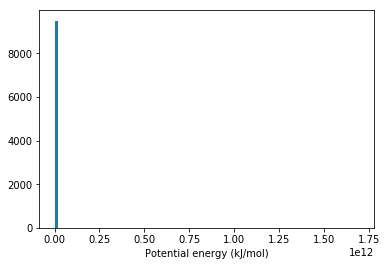

In [33]:
# Histgram
plt.hist(pe_list[500:], bins=100)
plt.xlabel('Potential energy (kJ/mol)')